This colab has an [accompanying video](https://www.youtube.com/watch?v=o6JNHoGUXCo)

In [ ]:
!pip install open_spiel

     |████████████████████████████████| 4.2 MB 18.2 MB/s 


In [ ]:
import itertools as it
from matplotlib import pyplot as plt
import numpy as np
import pyspiel

from open_spiel.python.algorithms import exploitability
from open_spiel.python import policy as policy_lib

np.set_printoptions(precision=3, suppress=True, floatmode='fixed')

In [ ]:
game = pyspiel.load_game('tic_tac_toe')
state = game.new_initial_state()

print(state)
while not state.is_terminal():
  action = np.random.choice(state.legal_actions())
  print(f'Taking action {action} {state.action_to_string(action)}')
  state.apply_action(action)
  print(state)
print(f'Game over; returns {state.returns()}')

...
...
...
Taking action 5 x(1,2)
...
..x
...
Taking action 8 o(2,2)
...
..x
..o
Taking action 3 x(1,0)
...
x.x
..o
Taking action 4 o(1,1)
...
xox
..o
Taking action 2 x(0,2)
..x
xox
..o
Taking action 1 o(0,1)
.ox
xox
..o
Taking action 6 x(2,0)
.ox
xox
x.o
Taking action 0 o(0,0)
oox
xox
x.o
Game over; returns [-1.0, 1.0]


In [ ]:
game = pyspiel.load_game('kuhn_poker')
print(game.get_type().pretty_print())

short_name: kuhn_poker
long_name: Kuhn Poker
dynamics: Sequential
chance_mode: ExplicitStochastic
information: ImperfectInformation
utility: ZeroSum
reward_model: Terminal
max_num_players: 10
min_num_players: 2
provides_information_state_string: true
provides_information_state_tensor: true
provides_observation_string: true
provides_observation_tensor: true
provides_factored_observation_string: true
parameter_specification: players=kInt***2***false


In [ ]:
policy = policy_lib.TabularPolicy(game)
print(policy.states_per_player)
print(policy.action_probability_array)

[['0', '0pb', '1', '1pb', '2', '2pb'], ['1p', '1b', '2p', '2b', '0p', '0b']]
[[0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]
 [0.500 0.500]]


In [ ]:
def print_policy(policy):
  for state, probs in zip(it.chain(*policy.states_per_player),
                          policy.action_probability_array):
    print(f'{state:6}   p={probs}')

print_policy(policy)

0        p=[0.500 0.500]
0pb      p=[0.500 0.500]
1        p=[0.500 0.500]
1pb      p=[0.500 0.500]
2        p=[0.500 0.500]
2pb      p=[0.500 0.500]
1p       p=[0.500 0.500]
1b       p=[0.500 0.500]
2p       p=[0.500 0.500]
2b       p=[0.500 0.500]
0p       p=[0.500 0.500]
0b       p=[0.500 0.500]


In [ ]:
print(exploitability.nash_conv(game, policy))

0.9166666666666666


In [ ]:
def new_reach(so_far, player, action_prob):
  """Returns new reach probabilities."""
  new = np.array(so_far)
  new[player] *= action_prob
  return new

def calc_cfr(state, reach):
  """Updates regrets; returns utility for all players."""
  if state.is_terminal():
    return state.returns() #如果是终止节点，则返回回报；注意这里的回报是个list,表示所有player的回报
  elif state.is_chance_node():
    return sum(prob * calc_cfr(state.child(action), new_reach(reach, -1, prob))
               for action, prob in state.chance_outcomes()) #如果是随机节点，则返回回报值的期望
  else:
    # We are at a player decision point.
    player = state.current_player()
    index = policy.state_index(state) 
    
    # Compute utilities after each action, updating regrets deeper in the tree.
    utility = np.zeros((game.num_distinct_actions(), game.num_players())) #utility为各个动作的原始回报值
    for action in state.legal_actions():
      prob = curr_policy[index][action]
      utility[action] = calc_cfr(state.child(action), new_reach(reach, player, prob))

    # Compute regrets at this state.
    cfr_prob = np.prod(reach[:player]) * np.prod(reach[player+1:]) #计算到达该state的概率，为除自己外其他玩家的概率的乘积
    value = np.einsum('ap,a->p', utility, curr_policy[index]) #value是期望回报值，为
    for action in state.legal_actions():
      regrets[index][action] += cfr_prob * (utility[action][player] - value[player]) #utility-value为遗憾值，遗憾值还要再乘上到达该state的概率

    # Return the value of this state for all players.
    return value

In [ ]:
game = pyspiel.load_game('kuhn_poker')
# game = pyspiel.load_game('turn_based_simultaneous_game(game=goofspiel(imp_info=true,num_cards=4,players=2,points_order=descending))')
policy = policy_lib.TabularPolicy(game)
initial_state = game.new_initial_state()
curr_policy = policy.action_probability_array.copy()
regrets = np.zeros_like(policy.action_probability_array)
eval_steps = []
eval_nash_conv = []
for step in range(129):
  # Compute regrets
  calc_cfr(initial_state, np.ones(1 + game.num_players()))
 
  # Find the new regret-matching policy
  floored_regrets = np.maximum(regrets, 1e-16)
  sum_floored_regrets = np.sum(floored_regrets, axis=1, keepdims=True)
  curr_policy = floored_regrets / sum_floored_regrets

  # Update the average policy
  lr = 1 / (1 + step)
  policy.action_probability_array *= (1 - lr)
  policy.action_probability_array += curr_policy * lr

  # Evaluate the average policy
  if step & (step-1) == 0:
    nc = exploitability.nash_conv(game, policy)
    eval_steps.append(step)
    eval_nash_conv.append(nc)
    print(f'Nash conv after step {step} is {nc}')

Nash conv after step 0 is 0.6666666666666656
Nash conv after step 1 is 0.5833333333333321
Nash conv after step 2 is 0.4814814814814816
Nash conv after step 4 is 0.27956581948517456
Nash conv after step 8 is 0.2045374078549737
Nash conv after step 16 is 0.0957019801773486
Nash conv after step 32 is 0.09602625213077909
Nash conv after step 64 is 0.05657638349057331
Nash conv after step 128 is 0.035512027875593655


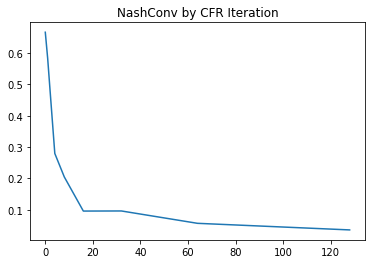

In [ ]:
fig, ax = plt.subplots()
ax.set_title("NashConv by CFR Iteration")
ax.plot(eval_steps, eval_nash_conv)
fig.show()

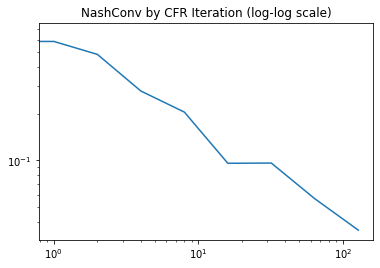

In [ ]:
fig, ax = plt.subplots()
ax.set_title("NashConv by CFR Iteration (log-log scale)")
ax.loglog(eval_steps, eval_nash_conv)
fig.show()

In [ ]:
# Display the whole policy
print_policy(policy)

# How likely are we to bet with a Jack?
alpha = policy.action_probability_array[policy.state_lookup['0']][1]
print(f'P(bet with Jack) = alpha = {alpha:.3}')

# How likely are we to bet with a King?
pK = policy.action_probability_array[policy.state_lookup['2']][1]
print(f'P(bet with King) = {pK:.3}, cf {alpha * 3:.3}')

# How likely are we to call with a Queen?
pQ = policy.action_probability_array[policy.state_lookup['1pb']][1]
print(f'P(call with Queen after checking) = {pQ:.3}, cf {alpha + 1/3:.3}')


0        p=[0.853 0.147]
0pb      p=[1.000 0.000]
1        p=[0.977 0.023]
1pb      p=[0.503 0.497]
2        p=[0.346 0.654]
2pb      p=[0.000 1.000]
1p       p=[0.975 0.025]
1b       p=[0.635 0.365]
2p       p=[0.000 1.000]
2b       p=[0.000 1.000]
0p       p=[0.665 0.335]
0b       p=[1.000 0.000]
P(bet with Jack) = alpha = 0.147
P(bet with King) = 0.654, cf 0.44
P(call with Queen after checking) = 0.497, cf 0.48


In [ ]:
def sample(actions_and_probs):
  actions, probs = zip(*actions_and_probs)
  return np.random.choice(actions, p=probs)

def policy_as_list(policy, state):
  return list(enumerate(policy.policy_for_key(state.information_state_string())))

def env_action(state):
  if state.is_chance_node():
    p = state.chance_outcomes()
  else:
    p = policy_as_list(fixed_policy, state)
  return sample(p)

def softmax(x):
  x = np.exp(x - np.max(x, axis=-1, keepdims=True))
  return x / np.sum(x, axis=-1, keepdims=True)

def generate_trajectory(state, player):
  trajectory = []
  while not state.is_terminal():
    if state.current_player() == player:
      action = sample(policy_as_list(rl_policy, state))
      trajectory.append((rl_policy.state_index(state), action))
    else:
      action = env_action(state)
    state.apply_action(action)
  return trajectory, state.returns()[player]


In [ ]:
fixed_policy = policy_lib.TabularPolicy(game)
rl_policy = policy_lib.TabularPolicy(game)
for _ in range(5):
  print(generate_trajectory(game.new_initial_state(), player=0))

([(0, 0)], -1.0)
([(4, 1)], 1.0)
([(0, 1)], 1.0)
([(4, 0)], 1.0)
([(0, 1)], -2.0)


In [ ]:
# Run REINFORCE
N = 10000
lr = 0.01
for step in range(N):
  for player in (0, 1):
    trajectory, reward = generate_trajectory(game.new_initial_state(), player)
    for s, a in trajectory:
      logits = np.log(rl_policy.action_probability_array[s])
      logits[a] += lr * reward
      rl_policy.action_probability_array[s] = softmax(logits)

In [ ]:
# Evaluate the policy
def evaluate(state, rl_policy, player):
  if state.is_terminal():
    return state.returns()[player]
  elif state.current_player() == player:
    ap = policy_as_list(rl_policy, state)
  elif state.is_chance_node():
    ap = state.chance_outcomes()
  else:
    ap = policy_as_list(fixed_policy, state)
  return sum(p * evaluate(state.child(a), rl_policy, player) for a, p in ap)

def eval(rl_policy):
  return (evaluate(game.new_initial_state(), rl_policy, player=0)
        + evaluate(game.new_initial_state(), rl_policy, player=1))

print_policy(rl_policy)
eval(rl_policy)

0        p=[0.273 0.727]
0pb      p=[0.690 0.310]
1        p=[0.000 1.000]
1pb      p=[0.458 0.542]
2        p=[0.000 1.000]
2pb      p=[0.297 0.703]
1p       p=[0.001 0.999]
1b       p=[0.031 0.969]
2p       p=[0.000 1.000]
2b       p=[0.000 1.000]
0p       p=[0.366 0.634]
0b       p=[0.677 0.323]


0.7675353731991239

In [ ]:
# Evaluate the greedy policy
greedy_policy = policy_lib.TabularPolicy(game)
greedy_policy.action_probability_array = (np.eye(game.num_distinct_actions())
              [np.argmax(rl_policy.action_probability_array, axis=-1)])

print_policy(greedy_policy)
eval(greedy_policy)

0        p=[0.000 1.000]
0pb      p=[1.000 0.000]
1        p=[0.000 1.000]
1pb      p=[0.000 1.000]
2        p=[0.000 1.000]
2pb      p=[0.000 1.000]
1p       p=[0.000 1.000]
1b       p=[0.000 1.000]
2p       p=[0.000 1.000]
2b       p=[0.000 1.000]
0p       p=[0.000 1.000]
0b       p=[1.000 0.000]


0.9166666666666665